In [1]:
import torch
from torch import nn
from torchvision import transforms
import torchvision
from torchsummary import summary

from collections import defaultdict

from PIL import Image
import albumentations as A
from tqdm import tqdm_notebook
import typing as tp

import pandas as pd
import numpy as np

import gc

In [2]:
trans = transforms.Compose([transforms.Resize(size=(34, 34)), transforms.ToTensor()])


cifar_train = torchvision.datasets.CIFAR10(root="/media/victor/DATA_DATA_DATA/CIFAR10",
                                           transform=trans,#transforms.functional.pil_to_tensor,
                                           download=True)

Files already downloaded and verified


In [3]:
class Resnet(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = torchvision.models.resnet18()
        self.net.fc = nn.Linear(512, 10)

    def forward(self, x):
        return self.net(x)

In [4]:
class Inception(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = torchvision.models.inception_v3()
        self.net.fc = nn.Linear(2048, 10)

    def forward(self, x):
        return self.net(x)

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import clear_output


def plot_loss(values, batch_size: int, lr: float, title_prefix: str):
    clear_output()
    with sns.plotting_context("notebook"), sns.axes_style("darkgrid"):
        train_loss = values["train_loss"]
        n = len(train_loss)

        plt.figure(figsize=(20, 10))

        plt.suptitle(f"{title_prefix}, batch size {batch_size}, learning rate {lr:.4f}")

        plt.subplot(2, 2, 1)
        plt.plot(range(1, n + 1), train_loss)
        plt.title('Train loss')
        plt.xlabel("Iterations")

        plt.subplot(2, 2, 2)
        error = values["noise_grad"]
        plt.plot(range(1, n + 1), error)
        plt.title(r'$\delta$ - noise magnitude')

        plt.subplot(2, 2, 3)
        alpha = [r / g for r, g in zip(values["noise_grad"], values["full_grad"])]
        plt.plot(range(1, n + 1), alpha)
        plt.title(r'$\alpha$ - relative noise coefficient')
        plt.xlabel("Iterations")

        plt.subplot(2, 2, 4)
        gamma = values["cosinus_grad"]
        plt.plot(range(1, n + 1), gamma)
        plt.title(r'$\gamma$ - cosine coefficient')
        plt.xlabel("Iterations")

        plt.show()


def get_list_grad_params(net: nn.Module) -> tp.List[torch.Tensor]:
    return [param.grad.detach().cpu() for param in net.parameters() if param.grad is not None]

def calc_grad_info(net: nn.Module, info: tp.List[torch.Tensor]):
    new_grads = get_list_grad_params(net)
    if not info:
        return new_grads
    return [new_grad + cur_grad for new_grad, cur_grad in zip(new_grads, info)]

def get_dif(grad_info_1: tp.List[torch.Tensor], grad_info_2: tp.List[torch.Tensor]) -> tp.List[torch.Tensor]:
    return [grad_1 - grad_2 for grad_1, grad_2 in zip(grad_info_1, grad_info_2)]

def mult_grad(info: tp.List[torch.Tensor], mult: float):
    return [grad * mult for grad in info] 

def get_grad_norm(grads: tp.List[torch.Tensor]):
    return np.sqrt(sum(grad.norm().item() ** 2 for grad in grads))

def get_cosinus_grad(grad_info_1: tp.List[torch.Tensor], grad_info_2: tp.List[torch.Tensor]) -> tp.List[torch.Tensor]:
    sc = sum([(grad_1 * grad_2).sum() for grad_1, grad_2 in zip(grad_info_1, grad_info_2)]).item()
    return sc / get_grad_norm(grad_info_1) / get_grad_norm(grad_info_2)


def calc_matrix_cosinus(grads: tp.List[tp.List[torch.Tensor]]):
    a = [[0 for i in range(len(grads))] for j in range(len(grads))]
    for i in range(len(grads)):
        for j in range(len(grads)):
            a[i][j] = get_cosinus_grad(grads[i], grads[j])
    return a


In [18]:
def train_cycle(
    model,
    optim,
    criterion,
    epochs,
    device,
    dataloader,
    mult: float,
    verbose=True,
    bound_batches = None,
    single_loader = None,
    step: int = 1,
    output_data: dict = None
):
    history = defaultdict(list)

    for _ in range(epochs):
        model.train()
        
        full_grad = []
        cur_grad = []
        K = 50
        k = 0

        grads = []

        # for x, y in tqdm_notebook(single_loader):
        #     k += 1
        #     optim.zero_grad()
        #     x = x.to(device).type(torch.float32)
        #     logits = model(x)
        #     y_ = y.to(device)
        #     # print(logits, logits)
        #     loss_batch = criterion(logits, y_)
        #     loss_batch.backward()
        #     # full_grad = calc_grad_info(model, full_grad)
        #     cur_grad = mult_grad(get_list_grad_params(model), mult=mult)
        #     grads.append(cur_grad)
        #     del x
        #     del y
        #     if 'cuda' in device:
        #         torch.cuda.synchronize()
        #         torch.cuda.empty_cache()
        #         gc.collect()
        #     if k == K:
        #         break
        
        # history["cosine_distr"].append(calc_matrix_cosinus(grads))
        # del grads

        for x, y in tqdm_notebook(dataloader):
            optim.zero_grad()
            x = x.to(device).type(torch.float32)
            logits = model(x)
            y_ = y.to(device)
            # print(logits, logits)
            loss_batch = criterion(logits, y_)
            loss_batch.backward()
            # optim.step()
            full_grad = calc_grad_info(model, full_grad)
            cur_grad = mult_grad(get_list_grad_params(model), mult=mult)
            del x
            del y
            if 'cuda' in device:
                torch.cuda.synchronize()
                torch.cuda.empty_cache()
                gc.collect()

        history["estimation_grad"].append(get_grad_norm(cur_grad))
        history["full_grad"].append(get_grad_norm(full_grad))
        history["noise_grad"].append(get_grad_norm(get_dif(full_grad, cur_grad)))
        history["cosinus_grad"].append(get_cosinus_grad(cur_grad, full_grad))
        optim.step()
        loss_ = loss_batch.detach().item()
        history["train_loss"].append(loss_)
        
        if verbose:
            plot_loss(history,
                      batch_size=output_data["batch_size"],
                      lr=output_data["lr"],
                      title_prefix=output_data["title_prefix"])

    return model, history

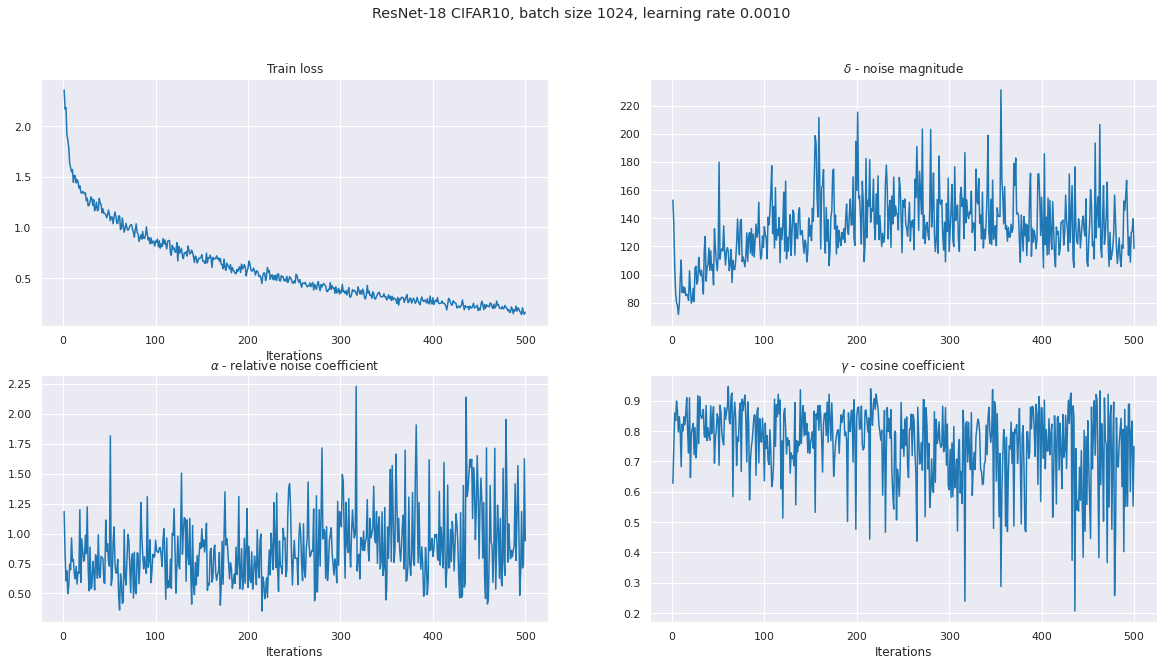

In [19]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"

model = Resnet().to(device)

batch_size: int = 1024
workers: int = 6
learning_rate = 1e-3

output_data = {
    "batch_size": batch_size,
    "lr": learning_rate,
    "title_prefix": "ResNet-18 CIFAR10"
}

dataloader_train = torch.utils.data.DataLoader(cifar_train,
                                               num_workers=workers,
                                               batch_size=batch_size,
                                               sampler=torch.utils.data.RandomSampler(cifar_train))

single_train = torch.utils.data.DataLoader(cifar_train,
                                               num_workers=workers,
                                               batch_size=1,
                                               sampler=torch.utils.data.RandomSampler(cifar_train))


optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()
verbose = True

epochs = 500

model, history = train_cycle(model,
                             optimizer,
                             criterion,
                             epochs,
                             device,
                             dataloader_train,
                             single_loader=single_train,
                             mult=len(cifar_train) / batch_size,
                             output_data=output_data)

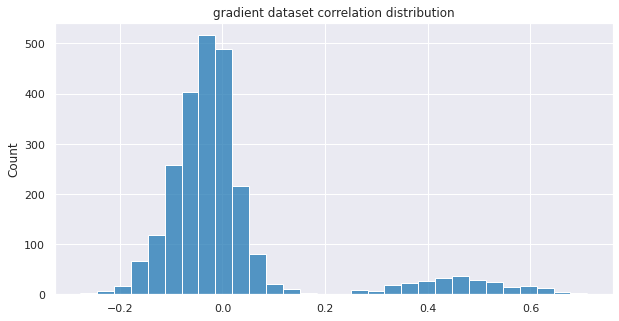

In [8]:
with sns.plotting_context("notebook"), sns.axes_style("darkgrid"):
    plt.figure(figsize=(10, 5))

    j = -1
    data = [y for x in history["cosine_distr"][j] for y in x if y < 1]

    # data = [y for x in history["cosine_distr"][-1] for y in x]

    sns.histplot(data, bins=30)
    plt.title(r'gradient dataset correlation distribution')

    plt.show()

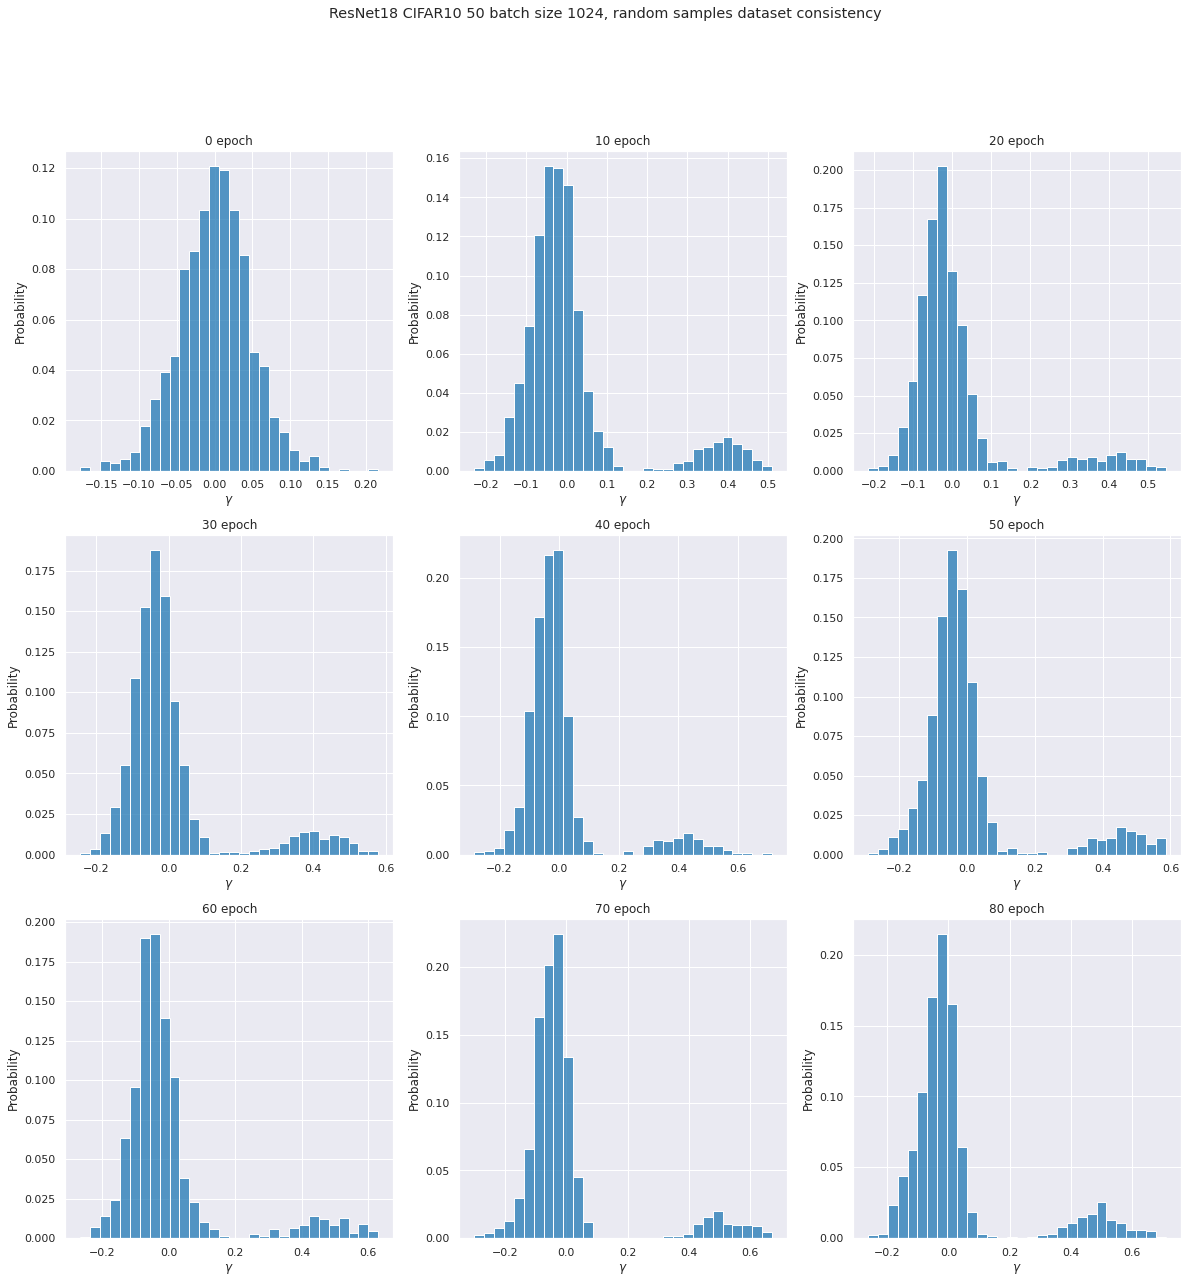

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import clear_output

with sns.plotting_context("notebook"), sns.axes_style("darkgrid"):
    plt.figure(figsize=(20, 20))

    plt.suptitle(f"ResNet18 CIFAR10 50 batch size 1024, random samples dataset consistency")

    for j in range(1, 10):
        plt.subplot(3, 3, j)
        data = [y for x in history["cosine_distr"][(j - 1) * 10] for y in x if y < 1]
        sns.histplot(data, bins=30, stat='probability')
        plt.title(f'{(j - 1) * 10} epoch')
        plt.xlabel(r"$\gamma$")

    plt.show()



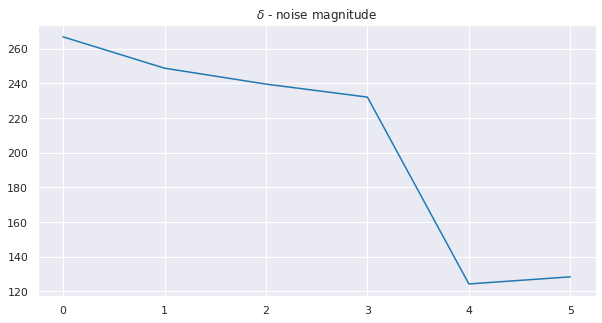

In [74]:
with sns.plotting_context("notebook"), sns.axes_style("darkgrid"):
    plt.figure(figsize=(10, 5))

    error = [g[1] for g in grad_history]

    plt.plot(range(len(error)), error)
    plt.title(r'$\delta$ - noise magnitude')

    plt.show()

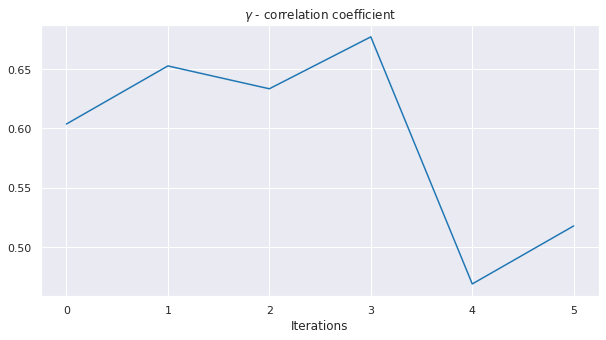

In [70]:
with sns.plotting_context("notebook"), sns.axes_style("darkgrid"):
    plt.figure(figsize=(10, 5))

    error = [g[3] for g in grad_history]

    plt.plot(range(len(error)), error)
    plt.title(r'$\gamma$ - correlation coefficient')
    plt.xlabel("Iterations")

    plt.show()

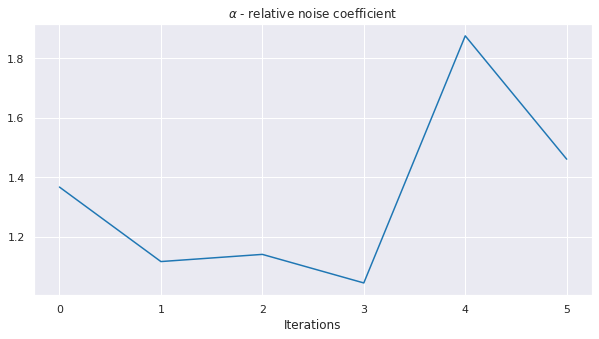

In [69]:
with sns.plotting_context("notebook"), sns.axes_style("darkgrid"):
    plt.figure(figsize=(10, 5))

    error = [grad[2] / grad[1] for grad in grad_history]

    plt.plot(range(len(error)), error)
    plt.title(r'$\alpha$ - relative noise coefficient')
    plt.xlabel("Iterations")

    plt.show()